In [ ]:
X.shape, y.shape

((834, 64, 1000), (834,))

In [ ]:
# X_train      = X[0:139,]
# Y_train      = y[0:139]
# X_validate   = X[139:208,]
# Y_validate   = y[139:208]
# X_test       = X[208:,]
# Y_test       = y[208:]

X_train, X_validate, Y_train, Y_validate=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
kernels, chans, samples = 1, 64, 1000

Y_train      = np_utils.to_categorical((Y_train+1)/2)
Y_validate   = np_utils.to_categorical((Y_validate+1)/2)

# convert data to NHWC (trials, channels, samples, kernels) format.
X_train      = X_train.reshape(X_train.shape[0],kernels, chans, samples)
X_validate   = X_validate.reshape(X_validate.shape[0],kernels, chans, samples)

In [ ]:
print(Y_train.sum(axis=0),Y_validate.sum(axis=0))

[[331. 336.]
 [336. 331.]] [[86. 81.]
 [81. 86.]]


In [ ]:
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
print(K.image_data_format())

channels_first


In [ ]:
# configure the EEGNet-8,2,16 model with kernel length of 32 samples (other 
# model configurations may do better, but this is a good starting point)
# model = EEGNet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 32, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')
# model= DeepConvNet(nb_classes=2, Chans = chans, Samples = samples,dropoutRate = 0.3)
model = htnet(nb_classes = 2, Chans = chans, Samples = samples, dropoutRate = 0.5, kernLength = 64, F1 = 8, D = 2, F2 = 16, dropoutType = 'Dropout')


# compile the model and set the optimizers
optimizer = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics = ['accuracy'])

checkpointer = ModelCheckpoint(filepath='checkpoint.h5', verbose=1,save_best_only=True)


fittedModel = model.fit(X_train, Y_train, batch_size =8, epochs = 100, verbose = 2, validation_data=(X_validate, Y_validate),callbacks=[checkpointer])

D:\anaconda3\envs\ecog\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
28/28 - 3s - loss: 0.6951 - accuracy: 0.5541 - val_loss: 0.6698 - val_accuracy: 0.5357

Epoch 00001: val_loss improved from inf to 0.66978, saving model to checkpoint.h5
Epoch 2/100
28/28 - 1s - loss: 0.6075 - accuracy: 0.6937 - val_loss: 0.6378 - val_accuracy: 0.6429

Epoch 00002: val_loss improved from 0.66978 to 0.63785, saving model to checkpoint.h5
Epoch 3/100
28/28 - 1s - loss: 0.5035 - accuracy: 0.8063 - val_loss: 0.5410 - val_accuracy: 0.7679

Epoch 00003: val_loss improved from 0.63785 to 0.54096, saving model to checkpoint.h5
Epoch 4/100
28/28 - 1s - loss: 0.4217 - accuracy: 0.8243 - val_loss: 0.4835 - val_accuracy: 0.8393

Epoch 00004: val_loss improved from 0.54096 to 0.48352, saving model to checkpoint.h5
Epoch 5/100
28/28 - 1s - loss: 0.3537 - accuracy: 0.8649 - val_loss: 0.4525 - val_accuracy: 0.8214

Epoch 00005: val_loss improved from 0.48352 to 0.45245, saving model to checkpoint.h5
Epoch 6/100
28/28 - 1s - loss: 0.3293 - accuracy: 0.8874 - val_loss: 0.451

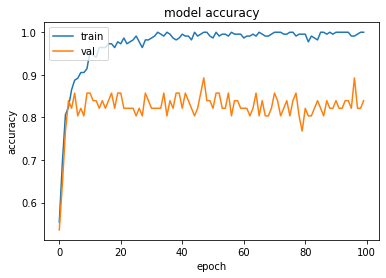

In [ ]:
plt.figure(0)
plt.plot(fittedModel.history['accuracy'])
plt.plot(fittedModel.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

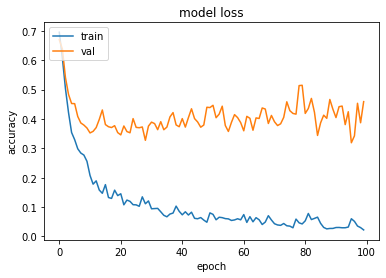

In [ ]:
plt.figure(1)
plt.plot(fittedModel.history['loss'])
plt.plot(fittedModel.history['val_loss'])
plt.title('model loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# model.load_weights('checkpoint.h5')
# probs       = model.predict(X_test)
# preds       = probs.argmax(axis = -1)  
# acc         = np.mean(preds == Y_test.argmax(axis=-1))
# print("Classification accuracy: %f " % (acc))

In [ ]:
model.load_weights('checkpoint.h5')
test_data=data['X_test']
true_labels=np.loadtxt('true_labels_bci3.txt')
print(test_data.shape,true_labels.shape)

(100, 64, 3000) (100,)


In [ ]:
j=0
test_segmented=np.empty((test_data.shape[0]*3,64,1000))
for i in range(test_data.shape[0]):
    test_segmented[j,:,:]=test_data[i,:,:1000]
    test_segmented[j+1,:,:]=test_data[i,:,1000:2000]
    test_segmented[j+2,:,:]=test_data[i,:,2000:3000]
    j=j+3

In [ ]:
true_labels_segmented=np.empty((true_labels.shape[0]*3),dtype=int)
j=0
for i in range(true_labels.shape[0]):
    true_labels_segmented[j]=true_labels[i]
    true_labels_segmented[j+1]=true_labels[i]
    true_labels_segmented[j+2]=true_labels[i]
    j=j+3

In [ ]:
test_segmented.shape, true_labels_segmented.shape

((300, 64, 1000), (300,))

In [ ]:
new_test_data= test_segmented.reshape(test_segmented.shape[0], kernels, chans, samples)
true_labels_segmented= np_utils.to_categorical((true_labels_segmented+1)/2)


In [ ]:
new_test_data= test_data.reshape(test_data.shape[0], kernels, chans, samples)
true_labels= np_utils.to_categorical((true_labels+1)/2)

In [ ]:
new_test_data.shape, true_labels.shape

((100, 1, 64, 3000), (100, 2))

In [ ]:
probs_test=model.predict(new_test_data)
preds_test=probs_test.argmax(axis=-1)
acc_test=np.mean(preds_test==true_labels.argmax(axis=-1))
print("Test Accuracy: %f"% (acc_test))

Test Accuracy: 0.580000
